# Imports

In [ ]:
# install all imports (also later ones) on the jupyter notebook silently if necessary, but check if already installed
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade numpy pandas matplotlib seaborn scikit-learn
!{sys.executable} -m pip install --upgrade jax optax torch 


In [1]:
import jax 
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
px = 1/plt.rcParams["figure.dpi"]

import os

# set how much memory in your local CPU/GPU will be pre-allocated for JAX
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".75"

import optax

# Data Preprocessing

In [2]:
# MNIST dataset, already flat and normalized
X_train_1 = jnp.load('../mnist_np/X_train_1.npy') 
X_train_2 = jnp.load('../mnist_np/X_train_2.npy') 
X_train_3 = jnp.load('../mnist_np/X_train_3.npy') 
X_train_4 = jnp.load('../mnist_np/X_train_4.npy') 
# create X_train out of 4 X_trains
X_train = jnp.concatenate([X_train_1, X_train_2, X_train_3, X_train_4], axis=0)
y_train = jnp.load('../mnist_np/y_train.npy')
X_test = jnp.load('../mnist_np/X_test.npy')
y_test = jnp.load('../mnist_np/y_test.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [3]:
def rate_encoding(key, X, sim_len=100):
    
    def bernoulli_encoding(key, spike_trains, sim_len):
        key, subkey = jax.random.split(key)
        return key, jax.random.bernoulli(key, spike_trains, (sim_len, spike_trains.shape[0], spike_trains.shape[1]))
    
    print('Encoding the data in batches of 2000 (going above take more time)')
    X_encoded = []
    batch_size = 2000
    for i in range(X.shape[0]//batch_size):
        key, X_encoded_ = bernoulli_encoding(key, X[i*batch_size:(i+1)*batch_size], sim_len=100)
        print(X_encoded_.shape)
        X_encoded.append(X_encoded_)

    return key, jnp.concatenate(X_encoded, axis=1)

# do rate encoding on X_test
key = jax.random.PRNGKey(9)
key, X_test_encoded = rate_encoding(key, X_test, sim_len=100)

Encoding the data in batches of 2000 (going above take more time)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)


In [4]:
# do rate encoding on Xtrain
key, X_train_encoded = rate_encoding(key, X_train, sim_len=100)

Encoding the data in batches of 2000 (going above take more time)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)


X_train_encoded
type: <class 'jaxlib.xla_extension.ArrayImpl'>:
shape: (100, 60000, 784),
datatype: bool
Label: 3.0, Input shape: (100, 784)


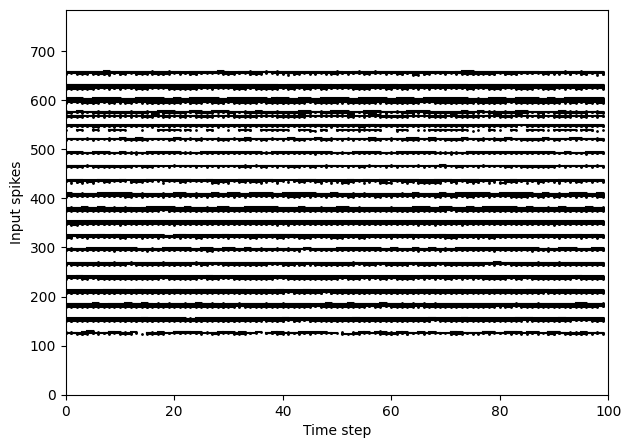

In [5]:
sim_len = 100
print(f'X_train_encoded'
      f'\ntype: {type(X_train_encoded)}:'
      f'\nshape: {X_train_encoded.shape},'
      f'\ndatatype: {X_train_encoded.dtype}')

# Raster plot of a single digit
sample_id = 10
input_0 = X_train_encoded[:, sample_id, :]
label_0 = y_train[sample_id]
print(f'Label: {label_0}, Input shape: {input_0.shape}')
# set the 0 to nan for plotting
input_0_to_plot = jnp.where(input_0 == 0, jnp.nan, input_0)
fig, ax = plt.subplots(1, 1, figsize=(700*px, 500*px))
xs = jnp.arange(sim_len)
for i in range(784):
    ax.plot(xs, input_0_to_plot[:, i]*i, label=f'Neuron {i}', marker='o', markersize=1, color='black')
ax.set_xlabel('Time step')
ax.set_ylabel('Input spikes')
ax.set_xlim(0, sim_len)
ax.set_ylim(0, 784)
plt.show()

## Dataset class

In [11]:
class MNISTDataset():
    # TODO 1: implement the MNIST dataset class
    # NOTE: you will need a __init___, __len__, and __getitem__ method
    def __init__(self, X_images,Y_labels):
        self.imgs = X_images
        self.lbls = Y_labels
    def __len__(self): # return length of dataset, i.e. nb of MNIST pictures
        return self.imgs.shape[1]

    def __getitem__(self, idx):
        return self.imgs[:,idx,:], self.lbls[idx]

In [12]:
# TODO 2: test functionality of MNISTDataset() class 
train_dataset = MNISTDataset(X_train_encoded, y_train)
test_dataset = MNISTDataset(X_test_encoded, y_test)

In [14]:
# TODO 3: test functionality of MNISTDataset() class
# test get_item
print(train_dataset[0])

# test len
print(len(train_dataset))

(Array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool), Array(5., dtype=float32))
60000


## Dataloader

In [10]:
from torch.utils.data import DataLoader

batch_size=128

# TODO 4: implement custom_collate_fn from Aleksej's code (JAX tutorial)
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch)) # *() unpacks data !

    labels= np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

# data loader from pytorch
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)